Notebook para comparar los modelos hechos del dataset sin ponderar (P1)

- **Tarea del backlog:** https://github.com/orgs/UCM-GIDIA-PD1/projects/7?pane=issue&itemId=103180618&issue=UCM-GIDIA-PD1%7Cc2425-R4%7C45
- **Propósito del código:** Comparaciones de los modelos del dataframe de peleas sin ponderar (P1).
- **Autor(es):** Telmo Aracama.  
- **Descripción y uso:** El objetivo de este notebook es ver que modelo nos da el resultado más óptimo.

# ÍNDICE

* [Carga de datos](#carga-de-datos)
* [Baseline](#baseline-para-p1)
* [Carga de modelos](#carga-de-modelos)
* [Evaluacion y comparacion de modelos](#evaluacion-y-comparacion-de-modelos)
* [Conclusion](#conclusion)

In [23]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, roc_curve, auc, 
                             precision_recall_curve, log_loss, brier_score_loss,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### CARGA DE DATOS

In [24]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

In [25]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

### BASELINE PARA P1

Gana el que haya dado más golpes

In [26]:
y_pred = X_test["SIG_STR_DIFF"] < 0
accuracy_score(y_test,y_pred)

0.7085798816568047

### CARGA DE MODELOS

In [28]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=13,
    random_state=42
)

# Entrenar el modelo
mejor_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=13,
                       random_state=42)

In [29]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_xgboost = XGBClassifier(
    alpha=0,
    colsample_bytree=0.7,
    gamma=0,
    reg_lambda=1.0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=2,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
mejor_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
ruta_train_x = os.path.join("..","..","..", "data", "P1","train_x.parquet")
x_train2 = pd.read_parquet(ruta_train_x) 
ruta_test_x = os.path.join("..","..","..", "data", "P1","test_x.parquet")
x_test2 = pd.read_parquet(ruta_test_x) 

ruta_train_y = os.path.join("..","..","..", "data", "P1","train_y.parquet")
y_train2 = pd.read_parquet(ruta_train_y) 
ruta_test_y = os.path.join("..","..","..", "data", "P1","test_y.parquet")
y_test2 = pd.read_parquet(ruta_test_y) 

# Crear el modelo con los mejores hiperparámetros encontrados (actualizados)
mejor_logistic = LogisticRegression(
    C=5.0,
    class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
    fit_intercept=True,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)

# Entrenar el modelo
mejor_logistic.fit(x_train2, y_train2)

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=5.0,
                   class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
                   random_state=42)

### EVALUACION Y COMPARACION DE MODELOS

**Comparacion de la metrica elegida**

En esta celda se realiza la comparación del rendimiento de los tres modelos utilizando la métrica F1. En primer lugar, se itera sobre los modelos almacenados en el diccionario modelos. Dependiendo del modelo, se selecciona el conjunto de test adecuado (para "Regresión Logística" se utiliza x_test2 y y_test2, mientras que para los otros se usa X_test y y_test).

Para cada modelo, se realizan las predicciones sobre los datos de prueba y se calcula el F1 Score, que se almacena en el diccionario f1_scores y se imprime en consola. Posteriormente, se convierte este diccionario en un DataFrame para presentar un resumen tabulado de los resultados.

Finalmente, se genera un gráfico de barras que compara visualmente el F1 Score de cada modelo, permitiendo identificar de forma clara cuál modelo presenta un mejor equilibrio entre precisión y recall.

In [31]:
def evaluar_metricas_complementarias_no_cm(modelo, X, y):
    y_pred = modelo.predict(X)
    y_prob = modelo.predict_proba(X)[:, 1]

    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "log_loss": log_loss(y, y_prob),
        "brier_score": brier_score_loss(y, y_prob)
    }

Árbol de Decisión F1 Score: 0.80
XGBoost F1 Score: 0.94
Regresión Logística F1 Score: 0.91

Resumen F1 Score:
                Modelo  F1 Score
0    Árbol de Decisión  0.801166
1              XGBoost  0.944676
2  Regresión Logística  0.908565


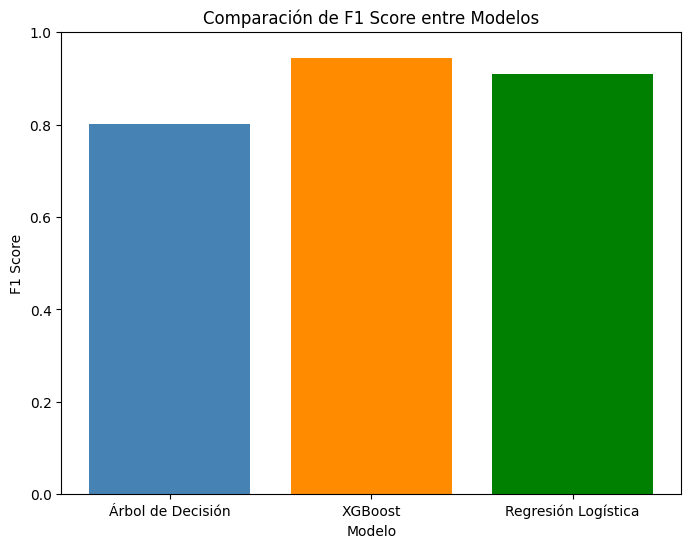

In [32]:
# Diccionario para almacenar el F1 score de cada modelo
f1_scores = {}

# Evaluar el F1 score para cada modelo
for nombre, modelo in modelos.items():
    if nombre == "Regresión Logística":
        X_eval, y_eval = x_test2, y_test2
    else:
        X_eval, y_eval = X_test, y_test
        
    y_pred = modelo.predict(X_eval)
    score = f1_score(y_eval, y_pred)
    f1_scores[nombre] = score
    print(f"{nombre} F1 Score: {score:.2f}")

# Convertir el diccionario a DataFrame para visualizar y graficar
df_f1 = pd.DataFrame(list(f1_scores.items()), columns=["Modelo", "F1 Score"])
print("\nResumen F1 Score:")
print(df_f1)

# Gráfico de barras para comparar el F1 score entre los modelos
plt.figure(figsize=(8,6))
plt.bar(df_f1["Modelo"], df_f1["F1 Score"], color=["steelblue", "darkorange", "green"])
plt.title("Comparación de F1 Score entre Modelos")
plt.xlabel("Modelo")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()

El resumen indica que el modelo XGBoost presenta el mejor desempeño, alcanzando un F1 Score de aproximadamente 0.94. Esto significa que XGBoost logra un excelente equilibrio entre precisión y recall en comparación con los otros modelos. La Regresión Logística, con un F1 Score alrededor de 0.91, se ubica en un nivel intermedio, mientras que el Árbol de Decisión, con un F1 de 0.80, muestra un rendimiento más moderado. En conjunto, estos resultados sugieren que XGBoost es el modelo más robusto para el problema, al lograr la mejor combinación de exactitud y sensibilidad en la clasificación.

**Metricas complementarias**

Esta celda tiene como objetivo evaluar de forma automática y comparar las métricas complementarias de cada uno de los modelos definidos. Primero, se calcula para cada modelo (usando los conjuntos de test correspondientes) un conjunto de métricas —accuracy, precisión, recall, F1, log loss y brier score— mediante la función definida. Estos resultados se almacenan en un diccionario que luego se transforma en un DataFrame para ordenar la información y facilitar su visualización. Finalmente, se genera un gráfico de barras agrupadas que permite comparar visualmente el desempeño de cada modelo en dichas métricas, ofreciendo una visión integral de cómo se comporta cada modelo en base a diferentes criterios de evaluación. Este análisis es fundamental para determinar, de manera comparativa, cuál modelo presenta un mejor equilibrio en su rendimiento.

In [33]:
# Para XGBoost
metricas_xgboost = evaluar_metricas_complementarias_no_cm(mejor_xgboost, X_test, y_test)

# Para Regresión Logística
metricas_logistic = evaluar_metricas_complementarias_no_cm(mejor_logistic, x_test2, y_test2)

# Para Árbol de Decisión
metricas_arbol = evaluar_metricas_complementarias_no_cm(mejor_arbol, X_test, y_test)

In [39]:
df_metrics = pd.DataFrame([
    ["XGBoost", 
     metricas_xgboost["accuracy"], 
     metricas_xgboost["precision"], 
     metricas_xgboost["recall"], 
     metricas_xgboost["f1"], 
     metricas_xgboost["log_loss"], 
     metricas_xgboost["brier_score"]],
    
    ["Regresión Logística", 
     metricas_logistic["accuracy"], 
     metricas_logistic["precision"], 
     metricas_logistic["recall"], 
     metricas_logistic["f1"], 
     metricas_logistic["log_loss"], 
     metricas_logistic["brier_score"]],
    
    ["Árbol de Decisión", 
     metricas_arbol["accuracy"], 
     metricas_arbol["precision"], 
     metricas_arbol["recall"], 
     metricas_arbol["f1"], 
     metricas_arbol["log_loss"], 
     metricas_arbol["brier_score"]]
], columns=["Modelo", "Accuracy", "Precision", "Recall", "F1", "Log Loss", "Brier Score"])

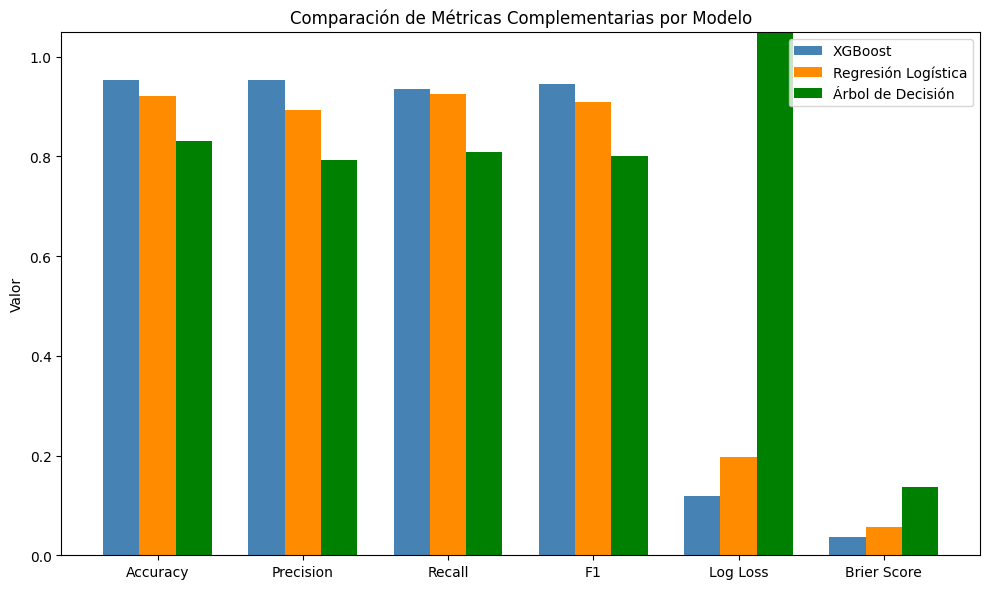

In [40]:
metricas = ["Accuracy", "Precision", "Recall", "F1", "Log Loss", "Brier Score"]
x = np.arange(len(metricas))  # posiciones para cada métrica
width = 0.25  # ancho de cada barra

# Datos por modelo
xgboost_vals = df_metrics[df_metrics["Modelo"] == "XGBoost"].iloc[0, 1:].values
logistic_vals = df_metrics[df_metrics["Modelo"] == "Regresión Logística"].iloc[0, 1:].values
arbol_vals = df_metrics[df_metrics["Modelo"] == "Árbol de Decisión"].iloc[0, 1:].values

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, xgboost_vals, width, label="XGBoost", color="steelblue")
ax.bar(x, logistic_vals, width, label="Regresión Logística", color="darkorange")
ax.bar(x + width, arbol_vals, width, label="Árbol de Decisión", color="green")

# Estética
ax.set_ylabel("Valor")
ax.set_title("Comparación de Métricas Complementarias por Modelo")
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()

plt.tight_layout()
plt.ylim(0, 1.05)
plt.show()

Estos resultados muestran un desempeño claramente diferenciado entre los tres modelos. El Árbol de Decisión alcanza un accuracy de aproximadamente 83.2%, con una precisión y recall que se reflejan en un F1 Score de 0.80; sin embargo, su log loss (2.49) es relativamente alto y el brier score (0.138) indica una calibración inferior de las probabilidades. En contraste, XGBoost presenta un rendimiento sobresaliente: su accuracy es del 95.4%, con precisión y recall de 0.953 y 0.936 respectivamente, lo que se traduce en un F1 Score de 0.9447; además, su log loss (0.1125) es muy bajo y el brier score (0.0337) confirma una excelente calibración. Por último, la Regresión Logística obtiene un accuracy de aproximadamente 92.2%, con precisión de 0.893, recall de 0.9246 y un F1 Score de 0.9085, situándose de manera intermedia en cuanto a log loss (0.1975) y brier score (0.0576) entre XGBoost y el Árbol de Decisión. En resumen, XGBoost es claramente el modelo con mejor desempeño, seguido de cerca por la Regresión Logística, mientras que el Árbol de Decisión presenta un rendimiento más moderado.

**Comparacion de curva ROC y AUC**

Esta celda tiene como objetivo comparar el rendimiento de los tres modelos a través de la Curva ROC y el cálculo del AUC para cada uno de ellos. Para ello, se selecciona el conjunto de test adecuado según el modelo (usando x_test2 y y_test2 para Regresión Logística, y X_test y y_test para los otros) y se obtiene la probabilidad de predicción de la clase positiva. Con estas probabilidades se calcula la tasa de falsos positivos (FPR) y la tasa de verdaderos positivos (TPR), que se usan para trazar la curva ROC. Además, se calcula el AUC, que resume el desempeño global del modelo en una sola métrica. Finalmente, se genera un gráfico que muestra las curvas ROC de todos los modelos en una misma figura, permitiendo identificar visualmente cuál modelo tiene un mejor equilibrio entre sensibilidad y especificidad, comparándolo también con una línea de referencia (un modelo aleatorio).

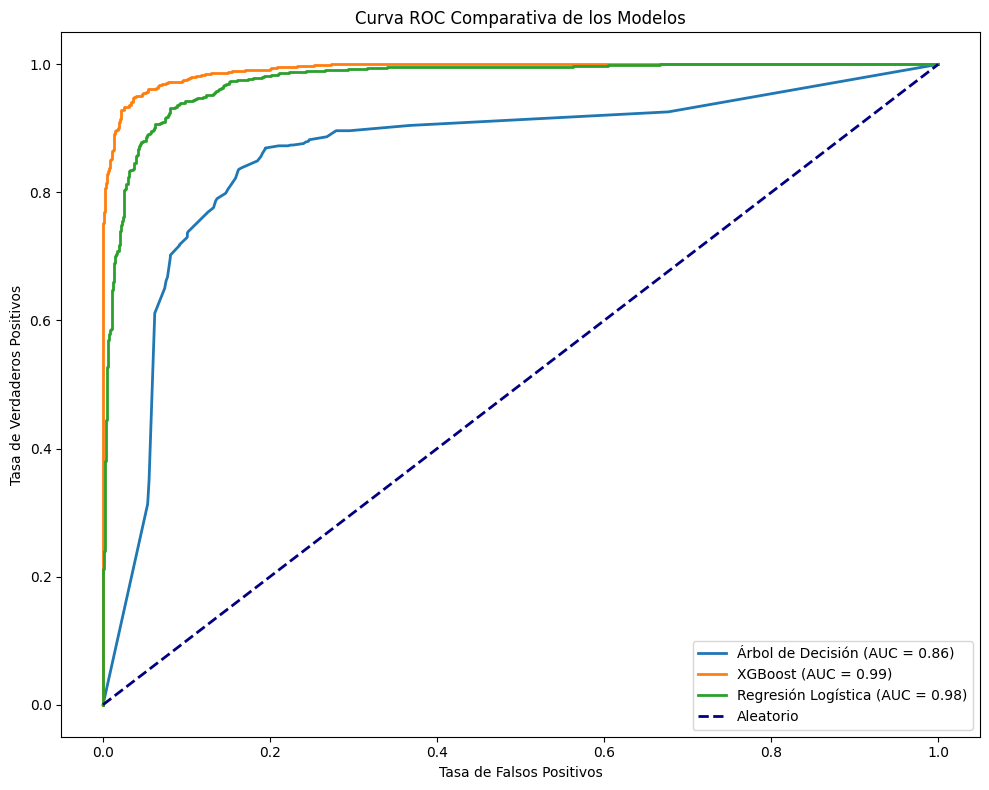

In [ ]:
# --- Curva ROC y AUC comparativa para los tres modelos ---
plt.figure(figsize=(10, 8))

for nombre, modelo in modelos.items():
    if nombre == "Regresión Logística":
        X_eval, y_eval = x_test2, y_test2
    else:
        X_eval, y_eval = X_test, y_test
        
    y_prob = modelo.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_eval, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"{nombre} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Aleatorio")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC Comparativa de los Modelos")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Los resultados muestran que el Árbol de Decisión presenta un AUC de 0.86, lo que indica un desempeño aceptable, pero relativamente inferior al de los otros modelos. XGBoost alcanza un AUC de 0.99, denotando una clasificación casi perfecta, mientras que la Regresión Logística se aproxima muy de cerca con un AUC de 0.98. En conjunto, estos valores confirman que tanto XGBoost como la Regresión Logística ofrecen un excelente equilibrio entre sensibilidad y especificidad, siendo significativamente superiores al Árbol de Decisión en este sentido.

**Resultado por segmentos relevantes para el problema**

En esta celda se realiza la evaluación por segmentos de cada modelo utilizando una variable de interés para segmentar el conjunto de datos. En concreto, se utiliza la variable "REV_DIFF" para dividir los datos en cuantiles (segmentos) y, en cada uno, se calcula el accuracy del modelo. El objetivo es analizar cómo varía el desempeño del modelo en diferentes rangos de "REV_DIFF". Esta variable fue elegida porque, según los análisis previos, es la variable a la que se le otorga menos importancia en los dos mejores modelos, por lo que resulta relevante entender si existen diferencias notables en el rendimiento cuando se segmenta el conjunto de datos según sus valores. Esta evaluación ayuda a identificar posibles debilidades o comportamientos atípicos en determinadas secciones del rango de "REV_DIFF".

Este análisis por segmentos basado en la variable "REV_DIFF" revela diferencias significativas en el desempeño entre los modelos. XGBoost mantiene un alto accuracy (0.96 y 0.92) en ambos segmentos, mientras que Regresión Logística muestra un rendimiento constante (0.92 y 0.91). Por otro lado, el Árbol de Decisión experimenta una notable caída de 0.84 a 0.75, lo que sugiere limitaciones en ciertos rangos de "REV_DIFF". En conjunto, estos resultados indican que XGBoost es el modelo más robusto según este criterio.

Este código evalúa el desempeño de un modelo XGBoost utilizando X_test y y_test. Primero, se obtienen las probabilidades de la clase 1 y las predicciones, y se crean tres series: una con todas las probabilidades, otra con las probabilidades de las predicciones correctas y una tercera con las de las incorrectas. A partir de estas series se forma un DataFrame, de donde se extraen 10 muestras representativas (aunque se ha eliminado la tabla que las mostraba).  
Luego, se genera un DataFrame "resultados" que combina las etiquetas reales y predichas, añadiendo una columna que indica si cada predicción es correcta. Con esta información se separan las muestras en aciertos y fallos.  
Si las características de X_test son numéricas, se calculan las medias de cada característica para el conjunto completo, para las muestras correctamente clasificadas y para las incorrectas. Finalmente se crea un DataFrame resumen con estas medias y se grafica su evolución por índice de columna. La idea es comparar cómo varían las características según si la predicción fue exitosa o no, lo que puede ayudar a interpretar y mejorar el modelo.

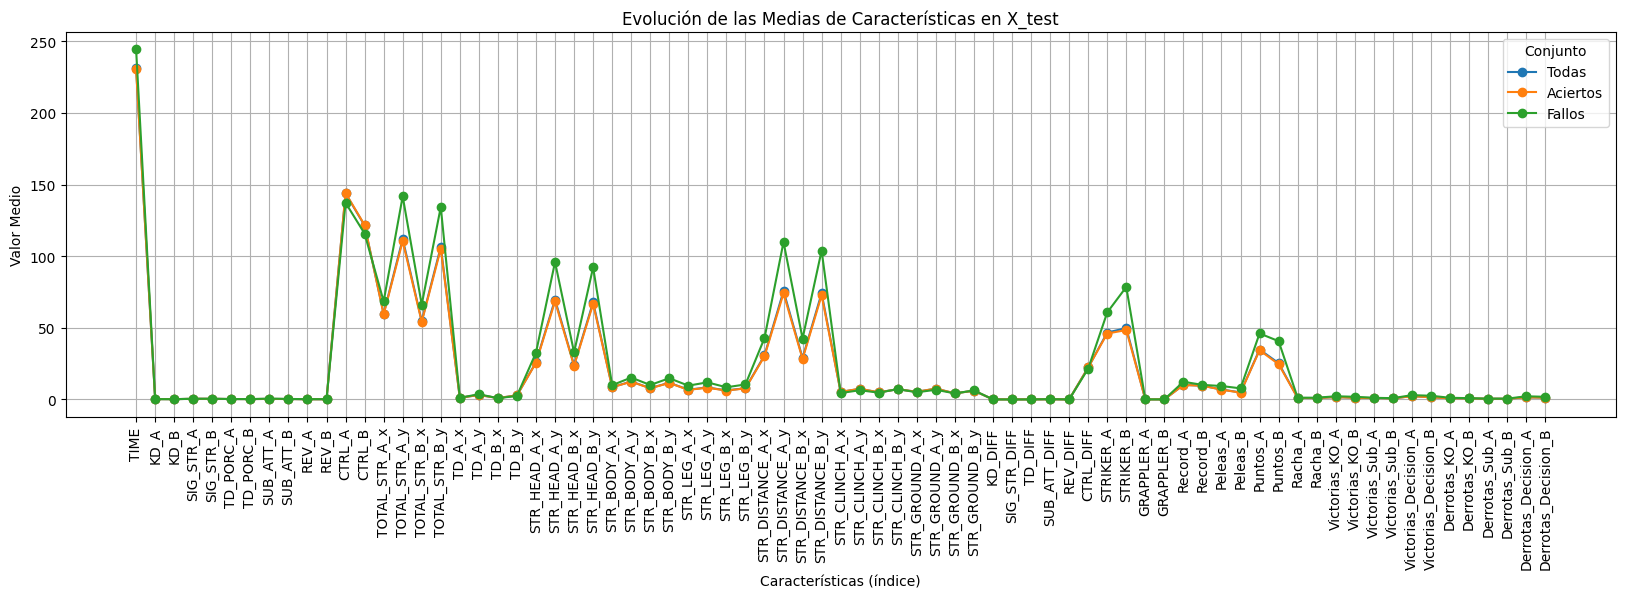

In [ ]:
# Obtener las probabilidades de la clase 1 y las predicciones en X_test
y_prob = mejor_xgboost.predict_proba(X_test)[:, 1]
y_pred = mejor_xgboost.predict(X_test)

mediasNormales = y_prob
mediasAciertos = np.where(y_pred == y_test, y_prob, np.nan)
mediasFallos = np.where(y_pred != y_test, y_prob, np.nan)

# Crear un DataFrame con las tres series
data = {
    'Todas': mediasNormales,
    'Aciertos': mediasAciertos,
    'Fallos': mediasFallos
}
df = pd.DataFrame(data)

# Seleccionar 10 muestras representativas (por ejemplo, las primeras 10)
df_subset = df.head(10)
# [Se ha eliminado la tabla que mostraba estos datos]

# Crear DataFrame de resultados con las etiquetas reales y predichas
resultados = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred
})
resultados["Correcto"] = resultados["Real"] == resultados["Predicho"]

# Dividir en aciertos y fallos
aciertos = resultados[resultados["Correcto"] == True]
fallos = resultados[resultados["Correcto"] == False]

# Si X_test es numérico, se pueden calcular las medias de cada característica:
mediasNormales = X_test.mean()
mediasAciertos = X_test.loc[aciertos.index].mean()
mediasFallos = X_test.loc[fallos.index].mean()

# Crear un DataFrame resumen con las medias de las características
data_resumen = {
    'Todas': mediasNormales,
    'Aciertos': mediasAciertos,
    'Fallos': mediasFallos
}
df_resumen = pd.DataFrame(data_resumen)

# Graficar la evolución de las medias (por índice de columna)
plt.figure(figsize=(20, 5))
df_resumen.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Evolución de las Medias de Características en X_test')
plt.xlabel('Características (índice)')
plt.ylabel('Valor Medio')
plt.legend(title='Conjunto')
plt.grid(True)
plt.xticks(ticks=range(len(df_resumen.index)), labels=df_resumen.index, rotation=90)
plt.show()

La gráfica muestra que las medias de las características de X_test para los casos de aciertos y fallos son muy similares, lo que indica que las diferencias entre ambos conjuntos son mínimas. Esto sugiere que el modelo XGBoost está realizando las predicciones de forma muy consistente y acertada, ya que la distribución de las variables de entrada no varía significativamente entre las muestras en las que acierta y aquellas en las que falla. En conclusión, la alta semejanza en las medias respalda la robustez y capacidad de generalización del modelo, lo que es un indicador favorable para su uso en producción.

**Influencia de las variables de entrada**

Esta celda se encarga de visualizar la importancia de las variables de entrada en cada uno de los modelos. El objetivo es identificar, mediante gráficos de barras, cuáles son las 10 variables más relevantes según cada modelo. Para modelos basados en árboles se utiliza el atributo "feature_importances_" y para modelos lineales se usan los coeficientes ("coef_"). Además, para Regresión Logística se utiliza X_train tal como está, mientras que en los otros modelos se elimina la columna "ROUND" si existe, pues puede no ser relevante. Esto permite entender el impacto de cada variable en la toma de decisiones de cada modelo.


Mostrando la importancia de las variables:


C:\Users\araca\AppData\Local\Temp\ipykernel_1904\1850568443.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")


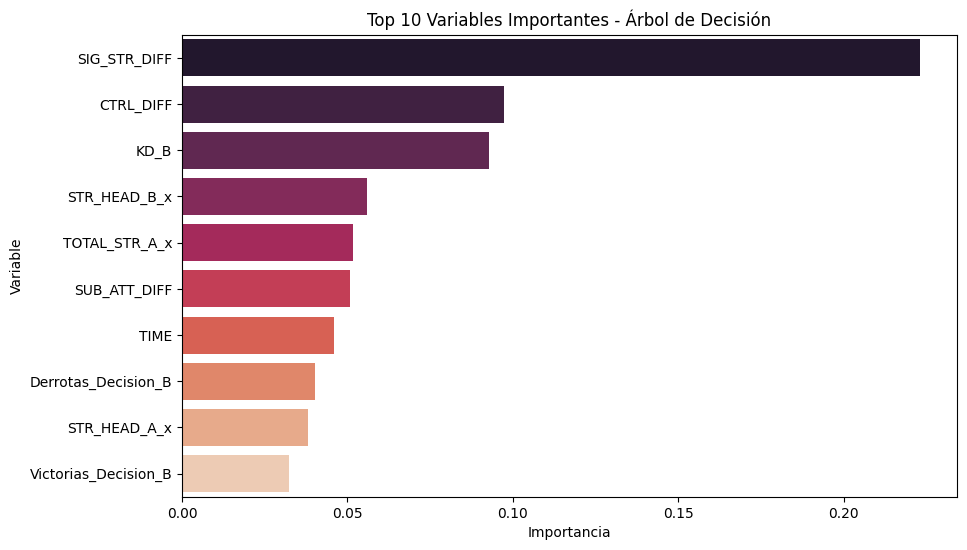

C:\Users\araca\AppData\Local\Temp\ipykernel_1904\1850568443.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")


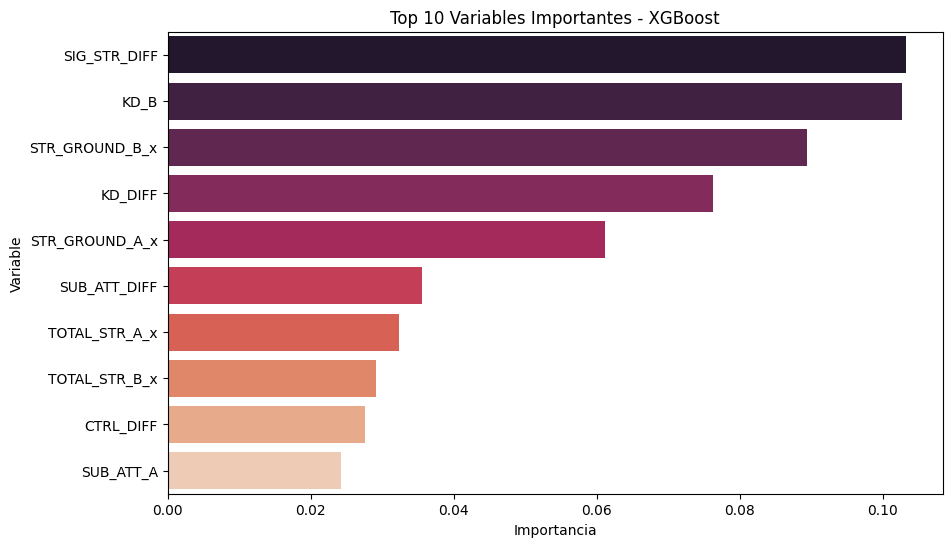

C:\Users\araca\AppData\Local\Temp\ipykernel_1904\1850568443.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")


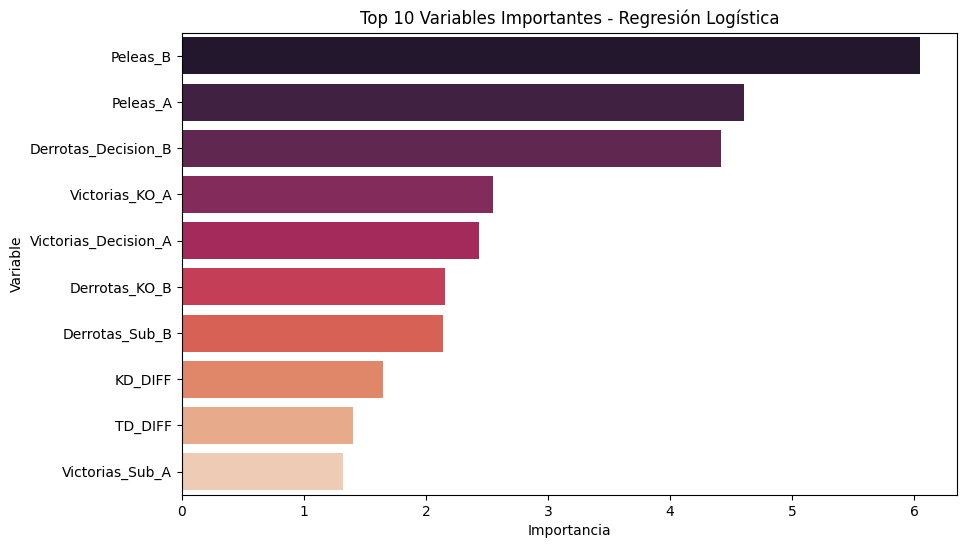

In [ ]:
# Función para graficar la importancia de variables
def plot_feature_importance(modelo, X_train, nombre):
    """
    Visualiza las 10 variables con mayor importancia.
    Se usa 'feature_importances_' para modelos basados en árboles o 'coef_' para regresión.
    """
    if hasattr(modelo, 'feature_importances_'):
        features = modelo.feature_names_in_ if hasattr(modelo, "feature_names_in_") else X_train.columns
        imp = modelo.feature_importances_
        df_imp = pd.DataFrame({"feature": features, "importance": imp}).sort_values("importance", ascending=False)
    elif hasattr(modelo, 'coef_'):
        features = modelo.feature_names_in_ if hasattr(modelo, "feature_names_in_") else X_train.columns
        coef = np.abs(modelo.coef_[0])
        df_imp = pd.DataFrame({"feature": features, "importance": coef}).sort_values("importance", ascending=False)
    else:
        print(f"No se pudo extraer la importancia para {nombre}")
        return
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")
    plt.title(f"Top 10 Variables Importantes - {nombre}")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()


# 4. Análisis de la influencia de las variables de entrada
print("\nMostrando la importancia de las variables:")
for nombre, modelo in modelos.items():
    # Para Regresión Logística se usa X_train directamente,
    # en otros modelos se elimina la columna "ROUND" si existe.
    if nombre == "Regresión Logística":
        plot_feature_importance(modelo, X_train, nombre)
    else:
        X_temp = X_train.drop(columns=["ROUND"], errors='ignore')
        plot_feature_importance(modelo, X_temp, nombre)

Observando los gráficos de importancias de las variables, se evidencia que los modelos asignan importancia a distintas variables. Por ejemplo, el Árbol de Decisión destaca especialmente la variable "SIG_STR_DIFF", mientras que a las demás no les otorga tanto peso. En cambio, XGBoost también enfatiza "SIG_STR_DIFF", pero equilibra su relevancia asignándole, además, la misma importancia a "KD_B" y otorgando gran peso a otras variables como "KD_DIFF" y "STR_GROUND" de ambos equipos. Por otro lado, la Regresión Logística se centra en las peleas de ambos peleadores, en las derrotas por decisión del peleador B y en las victorias por KO del peleador A. Estos hallazgos indican que cada modelo se fija en aspectos diferentes del conjunto de variables, lo que resalta la necesidad de considerar múltiples enfoques para obtener una visión completa del problema.

### CONCLUSION

Después de realizar una extensa comparación entre los modelos evaluados, se puede concluir lo siguiente: aunque la Regresión Logística y XGBoost presentan un comportamiento muy similar en muchos aspectos – tanto en términos de métricas complementarias como en la estabilidad de su rendimiento en diferentes segmentos de los datos – XGBoost se destaca como el mejor modelo debido a su rendimiento superior y su mayor robustez frente a las variaciones en el conjunto de datos.

Por otro lado, el Árbol de Decisión se queda significativamente atrás en comparación con los otros dos modelos. A pesar de sus resultados inferiores, su utilidad ha residido en el proceso de selección de variables, permitiéndonos identificar cuáles son las más relevantes para clasificar correctamente nuestros datos.

En definitiva, si bien la Regresión Logística mantiene un desempeño aceptable, los resultados globales favorecen a XGBoost como la opción óptima para la implementación final en el producto, ya que consigue un mejor equilibrio entre precisión, recall y otras métricas de interés, además de ofrecer una mayor estabilidad en distintas condiciones.